In [1]:
from eplus_ga import eppy_funcs as ef
from eplus_ga import sampling
from eplus_ga import objectives

from eplus_ga.problem import EPProblem
from eplus_ga.evaluator import EvaluatorEP

from sklearn import linear_model
from sklearn.model_selection import train_test_split

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from eplus_ga.parameters import RangeParameter, CategoryParameter, expand_plist

# Linear Regression Template

Linear Regression is a type of machine learning that assumes that the dataset that is given can be estimated and plotted as a linear function, and will then use that linear function to predict other values with decent accuracy.

Other types of machine learning algorithms (Neural Networks or Gaussian Processes) will have much greater accuracy, but Linear Regression is a very quick and simple way to estimate.

Before we can start creating the model and fitting data to it, we have to initialise all of the necessary EPlus variables, which include:

* The building we are modifying
* What parameters we want to modify
* The type of problem we are solving for
* The samples that we plan to use

More info can be found on these from the jupyter notebooks inside of the "Polished Examples" folder.

In [2]:
building = ef.get_building()

parameters = expand_plist(
    {'Mass NonRes Wall Insulation':
        {'Thickness': (0.01, 0.99)},
    'NonRes Fixed Assembly Window':
        {'U-Factor':(0.1,5)}
    }
)

problem = EPProblem(parameters, ['Electricity:Facility'])

samples = sampling.dist_sampler(sampling.seeded_sampler, problem, 500)

With those variables made we can then create the EPlus evaluator and use that to get our outputs, which we will be using to train and test our machine learning model

In [3]:
evaluator = EvaluatorEP(problem, building)

outputs = evaluator.df_apply(samples)

Now with all of that out of the way we can start on making our machine learning model.

Firstly we need to split the data into training data and testing data, which will be used to test:

In [4]:
train_in, test_in, train_out, test_out = train_test_split(samples, outputs, test_size=0.2)

Next we need to initiate the machine learning model we want to use, in this case we are using Linear Regression:

In [5]:
reg = linear_model.LinearRegression()

Linear Regression models are very simple and do not come with many options for customization, but they are very quick and easy to set up and use.

More info can be found [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

Afterwards we just need to calibrate the model by giving it the training input and the output data that we got before:

In [6]:
reg.fit(train_in, train_out)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

And with that we will have our results:

In [11]:
results = test_in.copy()
results['Energy Use'] = test_out
results['Predicted'] = reg.predict(test_in)

results.head()

Thickness  U-Factor    Energy Use     Predicted
289   0.447467  4.548590  1.847724e+09  1.840419e+09
336   0.612237  0.443207  1.833416e+09  1.826108e+09
116   0.517837  0.225747  1.836932e+09  1.829081e+09
305   0.457389  1.753639  1.826918e+09  1.834376e+09
135   0.967945  4.394876  1.842166e+09  1.821273e+09

If we want to check our accuracy with the R^2 value we can see it using score():

In [8]:
r_2 = reg.score(train_in, train_out)
r_2

0.49533631364130665

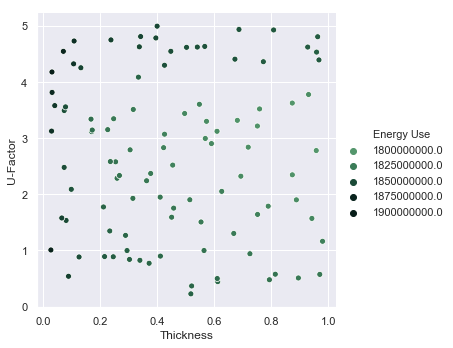

In [9]:
import seaborn as sns
sns.set(style="darkgrid")
sns.relplot(x="Thickness", y="U-Factor", hue="Energy Use", palette="ch:2.5,-.2,2,l=.7,d=.3", data=results);